In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math 
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import datetime


#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

import os
import xgboost as xgb
from xgboost import plot_importance


#train, test, cv splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score,confusion_matrix

#dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

#hyperparameter tuning
from bayes_opt import BayesianOptimization

#nlp
from pymystem3 import Mystem
import nltk 
from nltk.corpus import stopwords 

#showing all rows and cols without ...
pd.options.display.max_columns = 4000
pd.options.display.max_rows = 400
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


plt.rcParams['figure.figsize'] = [20, 16]

In [ ]:
nltk.download()

### Transliterating region and city: chaning from cyrillic alphabet to Latin alphabet
https://programminghistorian.org/lessons/transliterating

In [2]:
def Transliterate(word):
    cyrillic_translit={u'\u0410': 'A', u'\u0430': 'a',
                       u'\u0411': 'B', u'\u0431': 'b',
                        u'\u0412': 'V', u'\u0432': 'v',
                        u'\u0413': 'G', u'\u0433': 'g',
                        u'\u0414': 'D', u'\u0434': 'd',
                        u'\u0415': 'E', u'\u0435': 'e',
                        u'\u0416': 'Zh', u'\u0436': 'zh',
                        u'\u0417': 'Z', u'\u0437': 'z',
                        u'\u0418': 'I', u'\u0438': 'i',
                        u'\u0419': 'I', u'\u0439': 'i',
                        u'\u041a': 'K', u'\u043a': 'k',
                        u'\u041b': 'L', u'\u043b': 'l',
                        u'\u041c': 'M', u'\u043c': 'm',
                        u'\u041d': 'N', u'\u043d': 'n',
                        u'\u041e': 'O', u'\u043e': 'o',
                        u'\u041f': 'P', u'\u043f': 'p',
                        u'\u0420': 'R', u'\u0440': 'r',
                        u'\u0421': 'S', u'\u0441': 's',
                        u'\u0422': 'T', u'\u0442': 't',
                        u'\u0423': 'U', u'\u0443': 'u',
                        u'\u0424': 'F', u'\u0444': 'f',
                        u'\u0425': 'Kh', u'\u0445': 'kh',
                        u'\u0426': 'Ts', u'\u0446': 'ts',
                        u'\u0427': 'Ch', u'\u0447': 'ch',
                        u'\u0428': 'Sh', u'\u0448': 'sh',
                        u'\u0429': 'Shch', u'\u0449': 'shch',
                        u'\u042a': '"', u'\u044a': '"',
                        u'\u042b': 'Y', u'\u044b': 'y',
                        u'\u042c': "'", u'\u044c': "'",
                        u'\u042d': 'E', u'\u044d': 'e',
                        u'\u042e': 'Iu', u'\u044e': 'iu',
                        u'\u042f': 'Ia', u'\u044f': 'ia'}
    converted_word = ''
    for char in word:
        transchar = ''
        if char in cyrillic_translit:
            transchar = cyrillic_translit[char]
        else:
            transchar = char
        converted_word += transchar
    return converted_word

In [3]:
def CheckDistribution(y_train):
    sns.distplot(y_train, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(y_train)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('SalePrice distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(y_train, plot=plt)
    plt.show()
    

In [4]:
def PreProcess(train):
    train['HasImage'] = 0
    train.loc[train.image.notnull(),'HasImage']=1
#     train.drop('item_id',axis=1, inplace=True)

    #adding features
    cols = ['param_1', 'param_2', 'param_3','title','description']
    for col in cols:
        train[col+'_len'] = train[col].str.decode('utf-8').str.len()
    train['title_numb_of_words'] = train['title'].str.count(' ').add(1)
    train['description_numb_of_words'] = train['description'].str.count(' ').add(1)

    train.activation_date = pd.to_datetime(train.activation_date, errors='coerce')
    train['Day'] = train['activation_date'].dt.day
    train['Month_beg']=1
    train.loc[train.Day<=15, 'Month_beg'] = 0

    train.loc[train.parent_category_name=='Личные вещи','parent_category_name'] = train.loc[train.parent_category_name=='Lichnye veshchi','category_name']

    train= pd.get_dummies(train, columns=['user_type','parent_category_name'])
    
    train['region'] = train['region'].astype('category')
    train['city'] = train['city'].astype('category')
    train['category_name'] = train['category_name'].astype('category')
    train['param_1'] = train['param_1'].astype('category')
    train['param_2'] = train['param_2'].astype('category')
    train['param_3'] = train['param_3'].astype('category')
    

    cat_columns = train.select_dtypes(['category']).columns
    train[cat_columns] = train[cat_columns].apply(lambda x: x.cat.codes)
    train['param_1']=train['param_1'].add(1)
    train['param_2']=train['param_2'].add(1)
    train['param_3']=train['param_3'].add(1)
    
    train["activation_weekday"] = train["activation_date"].dt.weekday

    train.drop('activation_date', axis=1, inplace=True)
    train.drop('user_id', axis=1, inplace=True)
    train.drop('title', axis=1, inplace=True)
    train.drop('description', axis=1, inplace=True)
#     train.drop('image', axis=1, inplace=True)
    train.drop('param_1', axis=1, inplace=True)
    train.drop('param_2', axis=1, inplace=True)
    train.drop('param_3', axis=1, inplace=True)
    

    train.drop(train.loc[train.price>10000000000].index,inplace=True)
    
    ##TODO: predict price
    train.fillna(0,inplace=True)
    
    return train



In [231]:
# title, region, city, parent_category_name, category_name no nulls

#dealing with nulls
print len(combined_raw.loc[pd.isnull(combined_raw.param_1)])
print len(combined_raw.loc[pd.isnull(combined_raw.param_2)])
print len(combined_raw.loc[pd.isnull(combined_raw.param_3)])
print len(combined_raw.loc[pd.isnull(combined_raw.description)])
print len(combined_raw.loc[pd.isnull(combined_raw.price)])

84486
887771
1168896
116276
115947


In [314]:
combined_raw.loc[pd.isnull(combined_raw.description),'deal_probability'].value_counts()

0.000    90883
0.803     2605
0.865     1254
0.768     1012
0.126      722
0.273      471
0.827      437
0.158      365
0.129      349
0.785      306
0.150      303
0.389      269
0.340      246
0.125      244
0.133      213
0.158      185
0.394      184
0.127      165
0.122      164
0.394      158
0.207      157
0.865      144
0.150      139
0.155      136
0.315      130
0.181      115
0.789      108
0.118      104
0.210      103
0.124      103
0.134       98
0.137       87
0.239       78
0.485       72
0.130       67
0.162       65
0.129       60
0.143       60
0.108       59
0.432       58
0.099       58
0.121       57
0.186       56
0.250       55
0.214       52
0.207       49
0.234       48
0.080       45
0.115       45
0.228       45
0.132       44
0.209       44
0.074       43
0.239       43
0.112       42
0.105       42
0.107       42
0.184       40
0.203       40
0.113       39
0.147       38
0.035       38
0.113       38
0.175       36
0.216       36
0.209       35
0.109     

In [239]:
#maybe if description is null and price null we can discard? no
combined_raw.loc[pd.isnull(combined_raw.price) &( pd.isnull(combined_raw.description)) & pd.isnull(combined_raw.image)]

538

In [308]:
#let's review deal_prob 0's
deal0 = train_raw.loc[train_raw.deal_probability==0]

In [309]:
deal0.describe()

price  item_seq_number  image_top_1  deal_probability
count     937866.000       974617.000   933911.000        974617.000
mean      156253.284          560.894     1062.731             0.000
std      3634517.443         4040.039      962.204             0.000
min            0.000            1.000        0.000             0.000
25%          400.000           12.000      179.000             0.000
50%         1000.000           35.000      655.000             0.000
75%         3490.000          100.000     1752.000             0.000
max   1600025000.000       204429.000     3066.000             0.000

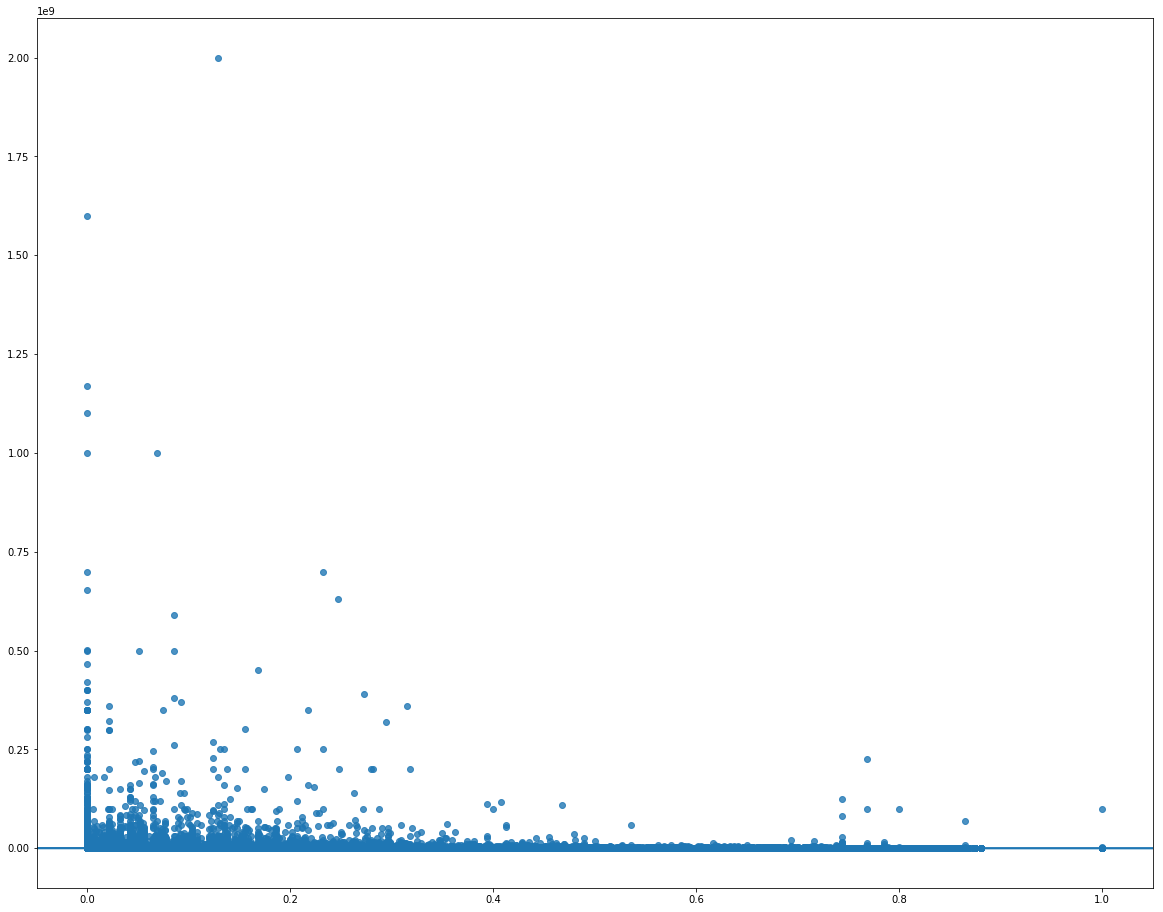

In [303]:
tmp = train_raw.loc[np.isnan(train_raw.price)==False]
sns.regplot(x=tmp['deal_probability'].values, y=tmp['price'].values)
plt.show()

In [310]:
test_raw.describe()

price  item_seq_number  image_top_1
count     477853.000       508438.000   465829.000
mean      279818.946          825.132     1297.959
std      5364218.323         5646.869      961.065
min            0.000            1.000        0.000
25%          500.000            8.000      467.000
50%         1500.000           30.000     1132.000
75%         8600.000           94.000     2218.000
max   3000060000.000       205064.000     3066.000

In [302]:
train_raw.drop(train_raw.loc[train_raw.price>10000000000].index,inplace=True)

In [293]:
test_raw.loc[test_raw.price>1000000000]

item_id       user_id               region       city  \
330798  dd31874a5cf7  8da15db69f96  Челябинская область  Челябинск   

       parent_category_name              category_name param_1  \
330798         Недвижимость  Коммерческая недвижимость   Сниму   

                   param_2 param_3                     title  \
330798  Торговое помещение     NaN  Сниму торговое помещение   

                                              description          price  \
330798  Сниму торговое помещение 100 м2  на первой лин... 3000060000.000   

        item_seq_number activation_date user_type image  image_top_1  
330798                1      2017-04-18   Private   NaN          nan

idea: for the given item deal_probability is comparasion between the same type of items and price 

In [225]:
# combined_raw.param_1.value_counts()
combined_raw.loc[pd.isnull(combined_raw.param_1),'parent_category_name'].value_counts()

Животные               26988
Бытовая электроника    22594
Для дома и дачи        22026
Хобби и отдых           6712
Личные вещи             2366
Недвижимость            2291
Транспорт                938
Услуги                   340
Для бизнеса              231
Name: parent_category_name, dtype: int64

In [229]:
combined_raw.loc[(pd.isnull(combined_raw.param_1))&(combined_raw.parent_category_name=='Для бизнеса')]

activation_date             category_name              city  \
719          2017-03-17  Оборудование для бизнеса           Искитим   
4751         2017-03-21  Оборудование для бизнеса            Ижевск   
38262        2017-03-27  Оборудование для бизнеса            Ижевск   
42356        2017-03-28  Оборудование для бизнеса         Краснодар   
46459        2017-03-23  Оборудование для бизнеса               Уфа   
58385        2017-03-18  Оборудование для бизнеса             Пермь   
61369        2017-03-24  Оборудование для бизнеса             Пермь   
64702        2017-03-18  Оборудование для бизнеса             Пермь   
73022        2017-03-28  Оборудование для бизнеса               Уфа   
94786        2017-03-18  Оборудование для бизнеса            Казань   
101328       2017-03-22  Оборудование для бизнеса       Новосибирск   
102123       2017-03-28  Оборудование для бизнеса         Краснодар   
112054       2017-03-21  Оборудование для бизнеса            Ижевск   
145663       2017-03-25            Готовый бизнес         Тальменка   
146520       2017-03-15  Оборудование для бизнеса   Нижний Новгород   
146574       2017-03-21  Оборудование для бизнеса               Уфа   
165865       2017-03-16  Оборудование для бизнеса         Краснодар   
231018       2017-03-25  Оборудование для бизнеса           Барнаул   
233028       2017-03-21  Оборудование для бизнеса               Уфа   
239196       2017-03-23  Оборудование для бизнеса               Уфа   
240125       2017-03-18  Оборудование для бизнеса            Казань   
252384       2017-03-15  Оборудование для бизнеса             Анапа   
275826       2017-03-16  Оборудование для бизнеса               Уфа   
285415       2017-03-18  Оборудование для бизнеса             Пермь   
287217       2017-03-21  Оборудование для бизнеса               Уфа   
292921       2017-03-23  Оборудование для бизнеса               Уфа   
301549       2017-03-27  Оборудование для бизнеса           Барнаул   
313972       2017-03-20  Оборудование для бизнеса    Ростов-на-Дону   
324182       2017-03-15  Оборудование для бизнеса           Иркутск   
329942       2017-03-16  Оборудование для бизнеса            Казань   
333896       2017-03-21  Оборудование для бизнеса            Ижевск   
334348       2017-03-22  Оборудование для бизнеса               Уфа   
345540       2017-03-28  Оборудование для бизнеса            Ижевск   
350431       2017-03-18  Оборудование для бизнеса      Нижний Тагил   
370354       2017-03-16            Готовый бизнес      Екатеринбург   
373616       2017-03-18  Оборудование для бизнеса       Новосибирск   
374123       2017-03-18  Оборудование для бизнеса             Пермь   
380338       2017-03-15  Оборудование для бизнеса               Уфа   
393853       2017-03-15  Оборудование для бизнеса            Ижевск   
396182       2017-03-18  Оборудование для бизнеса           Армавир   
399377       2017-03-18  Оборудование для бизнеса    Ростов-на-Дону   
403772       2017-03-16  Оборудование для бизнеса   Нижний Новгород   
415166       2017-03-16  Оборудование для бизнеса       Альметьевск   
441462       2017-03-24  Оборудование для бизнеса            Самара   
452181       2017-03-17  Оборудование для бизнеса       Новосибирск   
458758       2017-03-23  Оборудование для бизнеса               Уфа   
461185       2017-03-23  Оборудование для бизнеса               Уфа   
473980       2017-03-16  Оборудование для бизнеса            Ижевск   
504298       2017-03-22  Оборудование для бизнеса   Анжеро-Судженск   
526563       2017-03-25  Оборудование для бизнеса           Барнаул   
545587       2017-03-28  Оборудование для бизнеса         Челябинск   
550257       2017-03-27  Оборудование для бизнеса         Краснодар   
556708       2017-03-25            Готовый бизнес           Иркутск   
561200       2017-03-24  Оборудование для бизнеса            Ижевск   
564692       2017-03-26  Оборудование для бизнеса        Красноярск   
570372       2017-03-21  Оборудо

In [6]:
def Explore(train):
    print len(train), len(train.columns)
#     print "Number of users: " + str(len(train.user_id.unique()))
    print "Number of regions: " + str(len(train.region.unique()))
    print "Number of cities: " + str(len(train.city.unique()))
#     print "Number of parent categories: " + str(len(train.parent_category_name.unique()))
    print "Number of categories: " + str(len(train.category_name.unique()))
    print "Number of param1: " + str(len(train.param_1.unique()))
    print "Number of param2: " + str(len(train.param_2.unique()))
    print "Number of param3: " + str(len(train.param_3.unique()))
#     print "with image: " + str(len(train.loc[train.image.notnull()]))
#     print "without image: " + str(len(train.loc[train.image.isnull()]))
#     print "with image deal prob mean: " + str(train.loc[train.image.notnull()].deal_probability.mean())
#     print "without image: " + str(train.loc[train.image.isnull()].deal_probability.mean())
#     print train.parent_category_name.unique()
#     CheckDistribution(train.deal_probability)
#     print train.param_3.value_counts()
#     print train.groupby(['param_3']).deal_probability.mean()

#     print test.loc[test.parent_category_name=='Lichnye veshchi'].category_name.value_counts()
#     print test.loc[test.parent_category_name=='Lichnye veshchi'].groupby(['category_name']).deal_probability.mean()
    
#     plt.scatter(train.parent_category_name.value_counts(), train.groupby(['parent_category_name']).deal_probability.mean())

    plt.scatter(np.unique(train.Day),train.Day.value_counts())
    plt.show()

In [114]:
def xgb_rmse(preds, dtrain):
    # Courtesy of Tilii
    labels = dtrain.get_label()
    return 'rmse', math.sqrt(mean_squared_error(labels, preds))

In [115]:
def train_xgb(max_depth, subsample, min_child_weight, gamma, colsample_bytree):
    # Evaluate an XGBoost model using given params
    xgb_params = {
        'n_trees': 250,
        'eta': 0.01,
        'max_depth': int(max_depth),
        'subsample': max(min(subsample, 1), 0),
        'objective': 'reg:linear',
        'base_score': np.mean(Y), # base prediction = mean(target)
        'silent': 1,
        'min_child_weight': int(min_child_weight),
        'gamma': max(gamma, 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0)
    }
    scores = xgb.cv( xgb_params, dtrain, num_boost_round=1500,early_stopping_rounds=20, feval=xgb_rmse,verbose_eval=False, maximize=True, nfold=10)['test-rmse-mean'].iloc[-1]
    return scores

In [5]:
%%time
train_raw = pd.read_csv("Data/train.csv")
test_raw = pd.read_csv("Data/test.csv")

CPU times: user 18.4 s, sys: 3.06 s, total: 21.4 s
Wall time: 22.5 s


In [6]:
%%time
y = train_raw.deal_probability 
train_raw.drop('deal_probability', axis=1, inplace=True)

combined = train_raw.append(test_raw)
combined = PreProcess(combined)

CPU times: user 33.3 s, sys: 5.3 s, total: 38.6 s
Wall time: 39.2 s


In [7]:
train = combined[:len(train_raw)-1]
test = combined[len(train_raw)-1:]

In [8]:
test.head()

item_id  region  city  category_name     price  item_seq_number  \
0  6544e41a8817       4   318             10     0.000               66   
1  65b9484d670f      19   993              5  3000.000                4   
2  8bab230b2ecd      12   151              2 15000.000               15   
3  8e348601fefc      18  1319              4  4500.000               70   
4  8bd2fe400b89      14   243             42  4900.000               15   

                                               image  image_top_1  HasImage  \
0  a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...     2020.000         1   
1                                                  0        0.000         0   
2  8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...     2960.000         1   
3                                                  0        0.000         0   
4  bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...     1002.000         1   

   param_1_len  param_2_len  param_3_len  title_len  description_len  \
0       13.000        5.000        2.000         15           12.000   
1        8.000        0.000        0.000         16           88.000   
2       22.000        0.000        0.000          3          132.000   
3        9.000        7.000        0.000         17           93.000   
4       15.000        0.000        0.000         17           60.000   

   title_numb_of_words  description_numb_of_words  Day  Month_beg  \
0                    2                      2.000   18          1   
1                    2                     11.000   16          1   
2                    1                     22.000   17          1   
3                    3                     12.000   17          1   
4                    2                     10.000   15          0   

   user_type_Company  user_type_Private  user_type_Shop  \
0                  0                  1               0   
1                  0                  1               0   
2                  0                  1               0   
3                  0                  1               0   
4                  0                  1               0   

   parent_category_name_Бытовая электроника  parent_category_name_Для бизнеса  \
0                                         0                                 0   
1                                         0                                 0   
2                                         1                                 0   
3                                         0                                 0   
4                                         0                                 0   

   parent_category_name_Для дома и дачи  parent_category_name_Животные  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              0   
3                                     1                              0   
4                                     0                              0   

   parent_category_name_Недвижимость  parent_category_name_Транспорт  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   parent_category_name_Услуги  parent_category_name_Хобби и отдых  \
0                            0                                   0   
1                            0                                   1   
2                            0                                   0   
3                            0                                   0   
4                            0                                   0   

   activation_weekday  
0                   1  
1                   6  
2                   0

In [50]:
combined.shape

(2011862, 31)

In [176]:
train_raw.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description     price  \
0  Кокон для сна малыша,пользовались меньше месяц...   400.000   
1          Стойка для одежды, под вешалки. С бутика.  3000.000   
2  В хорошем состоянии, домашний кинотеатр с blu ...  4000.000   
3                             Продам кресло от0-25кг  2200.000   
4                           Все вопросы по телефону. 40000.000   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...     1008.000  
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...      692.000  
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...     3032.000  
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...      796.000  
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...     2264.000

In [197]:
print train_raw.loc[train_raw.user_type=='Private'].user_id.value_counts()
print train_raw.groupby('user_id')['deal_probability'].mean()

4b1f0d152f9f    129
eb385f07ad03     60
ecd1ceefa1a5     57
29f944c9c8f4     55
b665a8d3bcfe     55
c2853b06057e     54
89763633edbf     51
a504a860fe0c     51
5ec33737ca71     50
9208757989cf     47
5c4ed3fdfd9c     46
977ea4937397     45
103fea5d2827     45
8f198ae98731     45
f621889b4960     45
32caba0e8fc9     44
4ca5db32c2a6     44
1a64a44a2aec     44
9dde46b9be01     43
4f2bc9712b50     43
920adf6783c8     43
e9e9cc3b815c     42
c9e71cc376ad     42
cd20efb94e59     41
2210315d92e5     41
edd54f4b1b2a     41
79ca6f22d261     41
286537a315cb     40
0412340d3025     39
04d0805871df     39
462295910380     39
d202d6dd0e81     39
a8b3a50d8ccd     39
5329160dc067     39
6ab8e6c83be5     38
e65abb9beb0f     38
ca849ca8213f     38
9bb7fae0ad30     38
d19fa52b25ae     38
da072eaf6f1d     38
c252d5220f87     37
aa34b96fab58     37
e4eb47726b65     37
2b0c12567300     37
a3bf468d7379     37
c572b385e800     37
6d6d6ec78853     37
d6b84721e903     37
a234160a3b88     36
6e032abb5c5d     36


In [184]:
combined_raw = train_raw.append(test_raw)

In [207]:
len(train_raw.loc[train_raw]

45ba3f23bf25    1080
ee74bccca74f     980
60dfed1efb6e     907
b239811ad530     840
abcdd1ca1a5c     807
82348911d21c     752
a2ef0215eec3     695
b5003ea27e7a     684
2cd9f03d6527     657
82a96987d0f8     636
33d09dfdbd90     523
41f112adb74b     512
da6e825c0fdb     508
ac2280e23cbe     492
4bdf52a81f23     410
03082624a937     396
762434c0fd7e     382
743f3355d84a     370
4d2eb0bfc2a4     366
c2920abccec4     363
c337541311f8     361
9bdc2002bf51     360
818d647950cc     359
dc757d764977     355
1e19ac0f143f     354
838127830416     342
b2f33d77e08a     340
6be8de23ae72     340
b6f2091f0c0c     330
c4723507345b     329
626bcdec3f0b     328
18f28166ea10     327
37e959df25fa     327
7349b31129ee     321
1b160eb3c04d     320
a316ec571c4e     315
3b8134afbafe     314
a8f76e9334d4     312
ac35f736c6cb     308
f7454d5f7551     308
d9893595cffa     296
9bf10bd38655     295
f33560ee3a3d     289
ae6586719bec     288
f9b12b3fb49f     283
38ffbcd9e7c6     280
7da4605e0624     278
339e0789f620 

In [198]:
train_raw.loc[len(train_raw.use.value_counts())].sort_values('activation_date')
# .groupby('city')['deal_probability'].mean()

item_id       user_id             region    city  \
314258   9f4f629743a6  4b1f0d152f9f  Самарская область  Самара   
1064790  912bc8d867cb  4b1f0d152f9f  Самарская область  Самара   
72912    085affb9e571  4b1f0d152f9f  Самарская область  Самара   
1185727  92190dacef5e  4b1f0d152f9f  Самарская область  Самара   
1130502  2727c7e266d4  4b1f0d152f9f  Самарская область  Самара   
887738   e026e841e011  4b1f0d152f9f  Самарская область  Самара   
55178    f8569b086a0b  4b1f0d152f9f  Самарская область  Самара   
545410   7cd8fae21731  4b1f0d152f9f  Самарская область  Самара   
587808   a2c0ff18afa6  4b1f0d152f9f  Самарская область  Самара   
354381   a4355a2a1a85  4b1f0d152f9f  Самарская область  Самара   
1263127  3f922b26e2e8  4b1f0d152f9f  Самарская область  Самара   
357690   e3bfa70afd97  4b1f0d152f9f  Самарская область  Самара   
385731   0a4c607a014e  4b1f0d152f9f  Самарская область  Самара   
1201000  9200291cc017  4b1f0d152f9f  Самарская область  Самара   
1167223  5c0bb3562d94  4b1f0d152f9f  Самарская область  Самара   
480030   4dec451ae8fe  4b1f0d152f9f  Самарская область  Самара   
804101   fb685a846291  4b1f0d152f9f  Самарская область  Самара   
618919   ef1379100e18  4b1f0d152f9f  Самарская область  Самара   
1117695  d65e379478c8  4b1f0d152f9f  Самарская область  Самара   
686162   5abe9b57fc00  4b1f0d152f9f  Самарская область  Самара   
721976   58a55a1deb5d  4b1f0d152f9f  Самарская область  Самара   
738192   39b55ebfe742  4b1f0d152f9f  Самарская область  Самара   
1035790  fb02c5b7d0fb  4b1f0d152f9f  Самарская область  Самара   
1035731  f5edf5dae880  4b1f0d152f9f  Самарская область  Самара   
814928   c5d34bb8d839  4b1f0d152f9f  Самарская область  Самара   
862438   52c267a977fa  4b1f0d152f9f  Самарская область  Самара   
919485   8827a1a574ee  4b1f0d152f9f  Самарская область  Самара   
1144341  7f09d20bf472  4b1f0d152f9f  Самарская область  Самара   
339206   6d33240b0fbc  4b1f0d152f9f  Самарская область  Самара   
400781   a7d964b80384  4b1f0d152f9f  Самарская область  Самара   
138493   8feec8ac793e  4b1f0d152f9f  Самарская область  Самара   
52117    a3997850a26e  4b1f0d152f9f  Самарская область  Самара   
65294    03bee7d004d3  4b1f0d152f9f  Самарская область  Самара   
87827    c215dce897c4  4b1f0d152f9f  Самарская область  Самара   
327814   56b4a55ca4f6  4b1f0d152f9f  Самарская область  Самара   
208280   ef4bf8454f80  4b1f0d152f9f  Самарская область  Самара   
226832   57a4284b87cd  4b1f0d152f9f  Самарская область  Самара   
899718   48388f577ba0  4b1f0d152f9f  Самарская область  Самара   
1326054  01dc4d6573a0  4b1f0d152f9f  Самарская область  Самара   
1066113  f241373397e0  4b1f0d152f9f  Самарская область  Самара   
1408293  264125cbbc2f  4b1f0d152f9f  Самарская область  Самара   
1300383  b8851f6a0f0d  4b1f0d152f9f  Самарская область  Самара   
1295643  cfc922d483c2  4b1f0d152f9f  Самарская область  Самара   
1061825  e8f98daef78a  4b1f0d152f9f  Самарская область  Самара   
1040706  f92c36048662  4b1f0d152f9f  Самарская область  Самара   
1424516  c7108fdd063e  4b1f0d152f9f  Самарская область  Самара   
1406473  1fbb5dd9adf3  4b1f0d152f9f  Самарская область  Самара   
1275906  75099a75a31f  4b1f0d152f9f  Самарская область  Самара   
1027707  e6634164ba02  4b1f0d152f9f  Самарская область  Самара   
982368   6d269ef555ab  4b1f0d152f9f  Самарская область  Самара   
967267   3ee8c7d8bc87  4b1f0d152f9f  Самарская область  Самара   
1470004  84516002cc6f  4b1f0d152f9f  Самарская область  Самара   
1470901  c8c4ad1c1c31  4b1f0d152f9f  Самарская область  Самара   
906767   8b7411108704  4b1f0d152f9f  Самарская область  Самара   
902191   2440d8d3b5cd  4b1f0d152f9f  Самарская область  Самара   
1467792  7ec8e8b3c755  4b1f0d152f9f  Самарская область  Самара   
1221691  826c09eda39d  4b1f0d152f9f  Самарская область  Самара   
1078369  2fd0e2d86e96  4b1f0d152f9f  Самарская область  Самара   
1385574  97b21928ac49  4b1f0d152f9f  Самарская область  Самара   
1209541  205d8b153490  4b1f0d152f9f  Самарская область

In [203]:
train_raw.groupby(['region','parent_category_name'])['deal_probability'].mean()

region                   parent_category_name
Алтайский край           Бытовая электроника    0.180
                         Для бизнеса            0.118
                         Для дома и дачи        0.211
                         Животные               0.276
                         Личные вещи            0.086
                         Недвижимость           0.139
                         Транспорт              0.154
                         Услуги                 0.338
                         Хобби и отдых          0.117
Башкортостан             Бытовая электроника    0.173
                         Для бизнеса            0.063
                         Для дома и дачи        0.176
                         Животные               0.245
                         Личные вещи            0.070
                         Недвижимость           0.190
                         Транспорт              0.297
                         Услуги                 0.417
                         Хобби и отд

#### A Python wrapper of the Yandex Mystem 3.0 morphological analyzer
https://github.com/nlpub/pymystem3
Get russian stopwords from nltk.
<code>from nltk.corpus import stopwords 
stop = set(stopwords.words('russian'))</code>



In [ ]:
# Explore(train)
Explore(test)

In [ ]:
text = "Красивая мама красиво мыла раму"
m = Mystem()
lemmas = m.lemmatize(text)
print(''.join(lemmas))

In [ ]:
stop = set(stopwords.words('russian'))

In [ ]:
for s in stop:
    print s

In [15]:
#let's divide the train set into train and cv
X_train,X_cv, y_train, y_cv = train_test_split(train, y, test_size = 0.2, random_state = 43)

In [ ]:
scores_rf = cross_val_score(clf_rf,train, y, cv=10, scoring='mean_squared_error')
score_rf= np.sqrt(-scores_rf).mean()
print score_rf
y_rf_cv = cross_val_predict(clf_rf, train, y, cv=10, scoring='mean_squared_error')

In [119]:
train.head()

region  city  category_name  param_1  param_2  param_3     price  \
0      19   462             42      249        0        0   400.000   
1      17  1314             22      122        0        0  3000.000   
2      16  1290              2       84        0        0  4000.000   
3      21   950             42       38        0        0  2200.000   
4       4   318              0      278      124       47 40000.000   

   item_seq_number  image_top_1  HasImage  param_1_len  param_2_len  \
0                2     1008.000         1       25.000        0.000   
1               19      692.000         1        6.000        0.000   
2                9     3032.000         1       27.000        0.000   
3              286      796.000         1       20.000        0.000   
4                3     2264.000         1       10.000       10.000   

   param_3_len  title_len  description_len  title_numb_of_words  \
0        0.000         21           58.000                    3   
1        0.000         17           41.000                    3   
2        0.000         14           99.000                    2   
3        0.000         10           22.000                    1   
4        4.000         14           24.000                    3   

   description_numb_of_words  Day  Month_beg  user_type_Company  \
0                      7.000   28          0                  0   
1                      7.000   26          0                  0   
2                     16.000   20          0                  0   
3                      3.000   25          0                  1   
4                      4.000   16          0                  0   

   user_type_Private  user_type_Shop  \
0                  1               0   
1                  1               0   
2                  1               0   
3                  0               0   
4                  1               0   

   parent_category_name_Бытовая электроника  parent_category_name_Для бизнеса  \
0                                         0                                 0   
1                                         0                                 0   
2                                         1                                 0   
3                                         0                                 0   
4                                         0                                 0   

   parent_category_name_Для дома и дачи  parent_category_name_Животные  \
0                                     0                              0   
1                                     1                              0   
2                                     0                              0   
3                                     0                              0   
4                                     0                              0   

   parent_category_name_Недвижимость  parent_category_name_Транспорт  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               1   

   parent_category_name_Услуги  parent_category_name_Хобби и отдых  \
0                            0                                   0   
1                            0                                   0   
2                            0                                   0   
3                            0                                   0   
4                            0                                   0   

   activation_weekday  
0                   1  
1                   6  
2                   0  
3                   5  
4                   3

In [11]:
# Random Forest

clf_rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=6,random_state=43)
clf_rf.fit(train,y)
y_rf_test = clf_rf.predict(test)

In [12]:
#AdaBoost
clf_ada = AdaBoostRegressor(random_state=43)
clf_ada.fit(train,y)
y_ada_test = clf_ada.predict(test)

In [13]:
#bagging 
clf_bag = BaggingRegressor(random_state=43)
clf_bag.fit(train,y)
# clf_bag.fit(X_train , y_train )
# y_cv_predict = clf_bag.predict(X_cv)
# print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_bag_test = clf_bag.predict(test)


In [14]:
#gb  
clf_gb = GradientBoostingRegressor(random_state=43)
clf_gb.fit(train,y)
y_gb_test = clf_gb.predict(test)

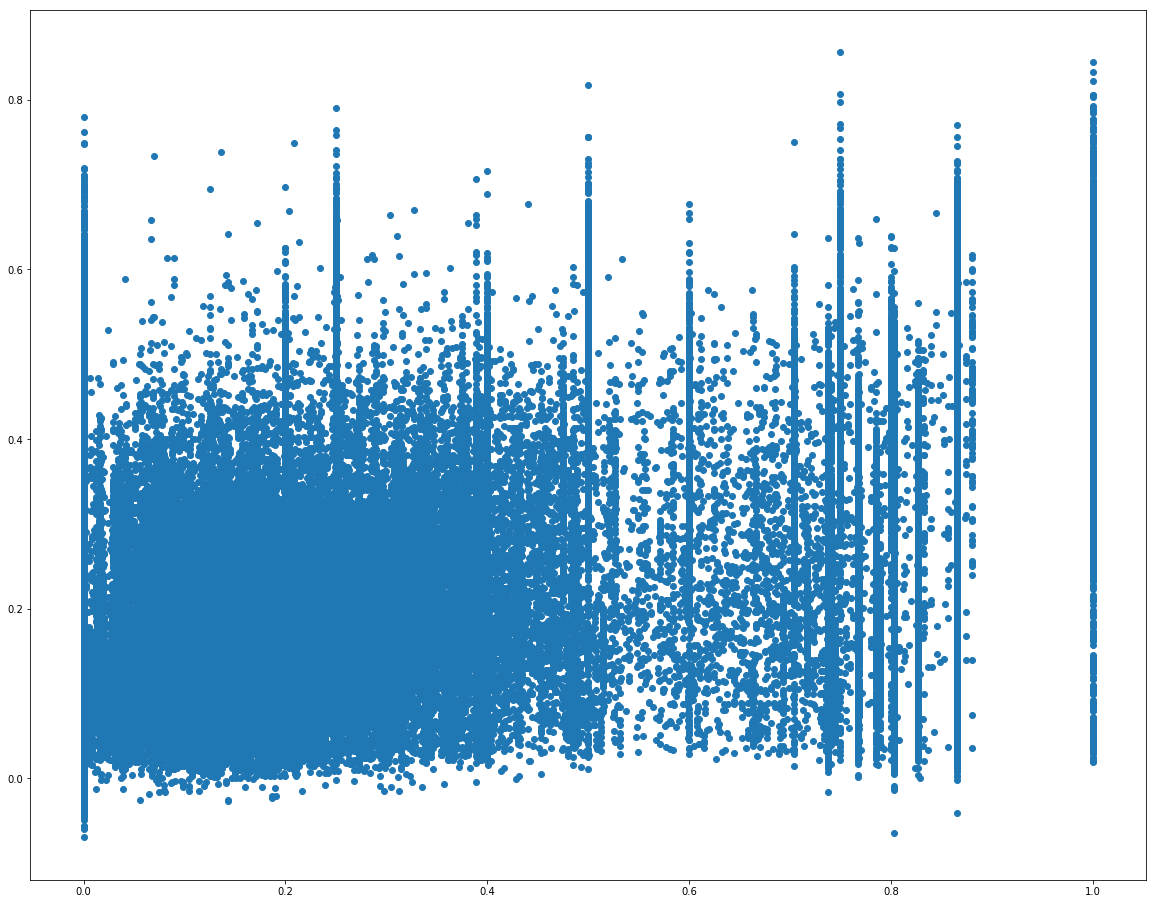

0.211788160475 0.231264848181


In [16]:
#xgb
clf_xgb = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.05, subsample= 0.72594007111201053, 
                           colsample_bytree=0.99039137352867346, 
                           min_child_weight= 10.569011344756881,
                           gamma=0.27084988920089037, max_depth= 10)
# clf_xgb = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.05, subsample= 0.55604562020224235, 
#                            colsample_bytree=0.10407208174818593, 
#                            min_child_weight= 12.563148316505455,
#                            gamma=8.4650552434599167, max_depth= 5)

clf_xgb.fit(X_train, y_train)
y_cv_predict = clf_xgb.predict(X_cv)
plt.scatter(y_cv, y_cv_predict)
plt.show()
print r2_score(y_cv, y_cv_predict), math.sqrt(mean_squared_error(y_cv, y_cv_predict))
y_xgb_test = clf_xgb.predict(test)


In [17]:
clf_xgb_all = xgb.XGBRegressor(n_estimators = 200, learning_rate=0.05, subsample= 0.72594007111201053, 
                           colsample_bytree=0.99039137352867346, 
                           min_child_weight= 10.569011344756881,
                           gamma=0.27084988920089037, max_depth= 10)
clf_xgb_all.fit(train, y)
y_xgb_test_all = clf_xgb_all.predict(test)

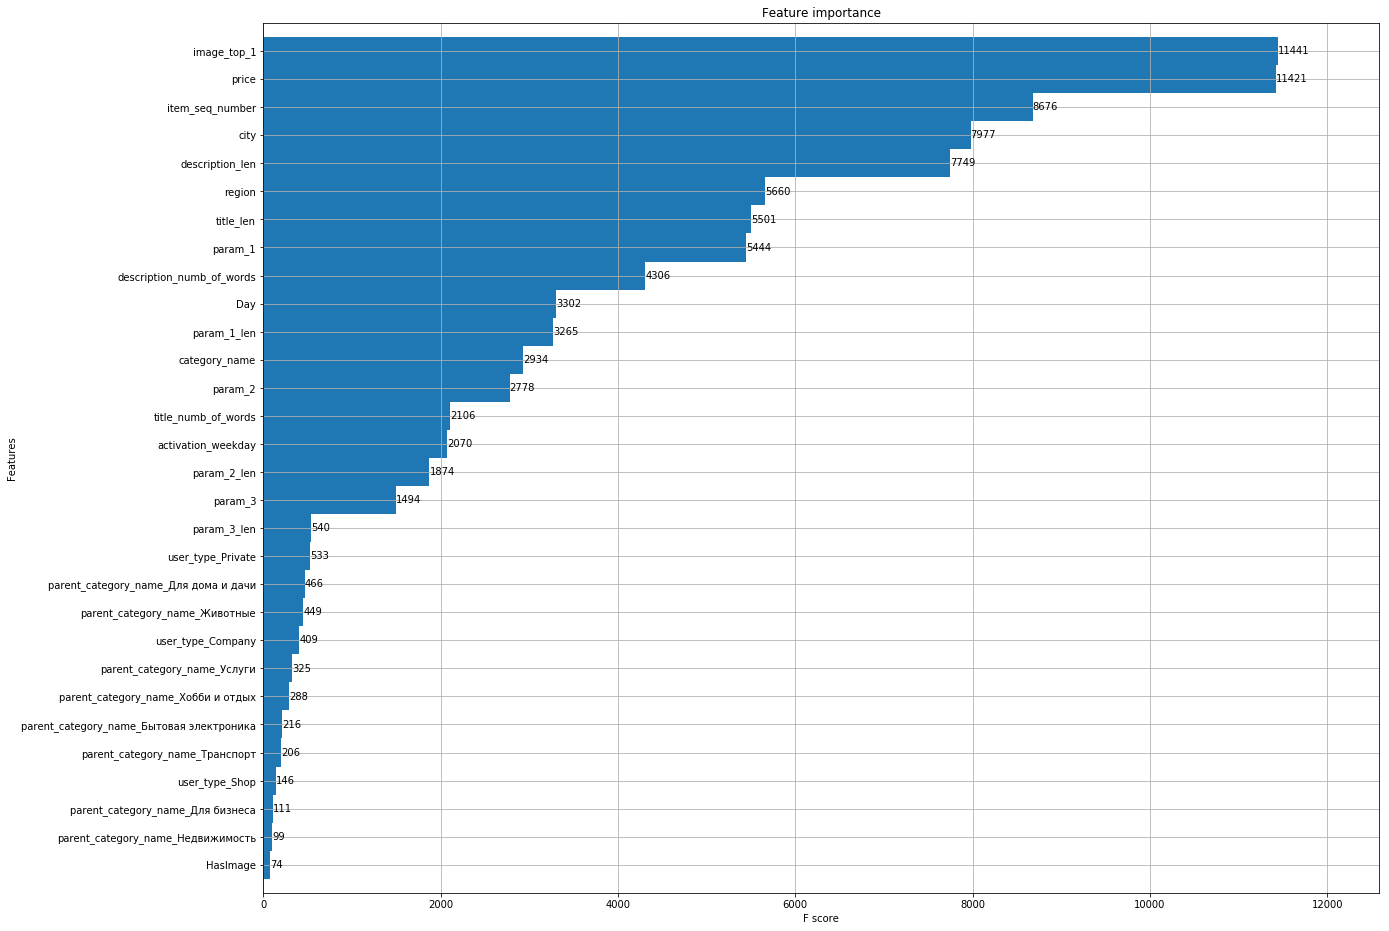

In [147]:
# plot feature importance using built-in function
plot_importance(clf_xgb, height=1)
plt.show()

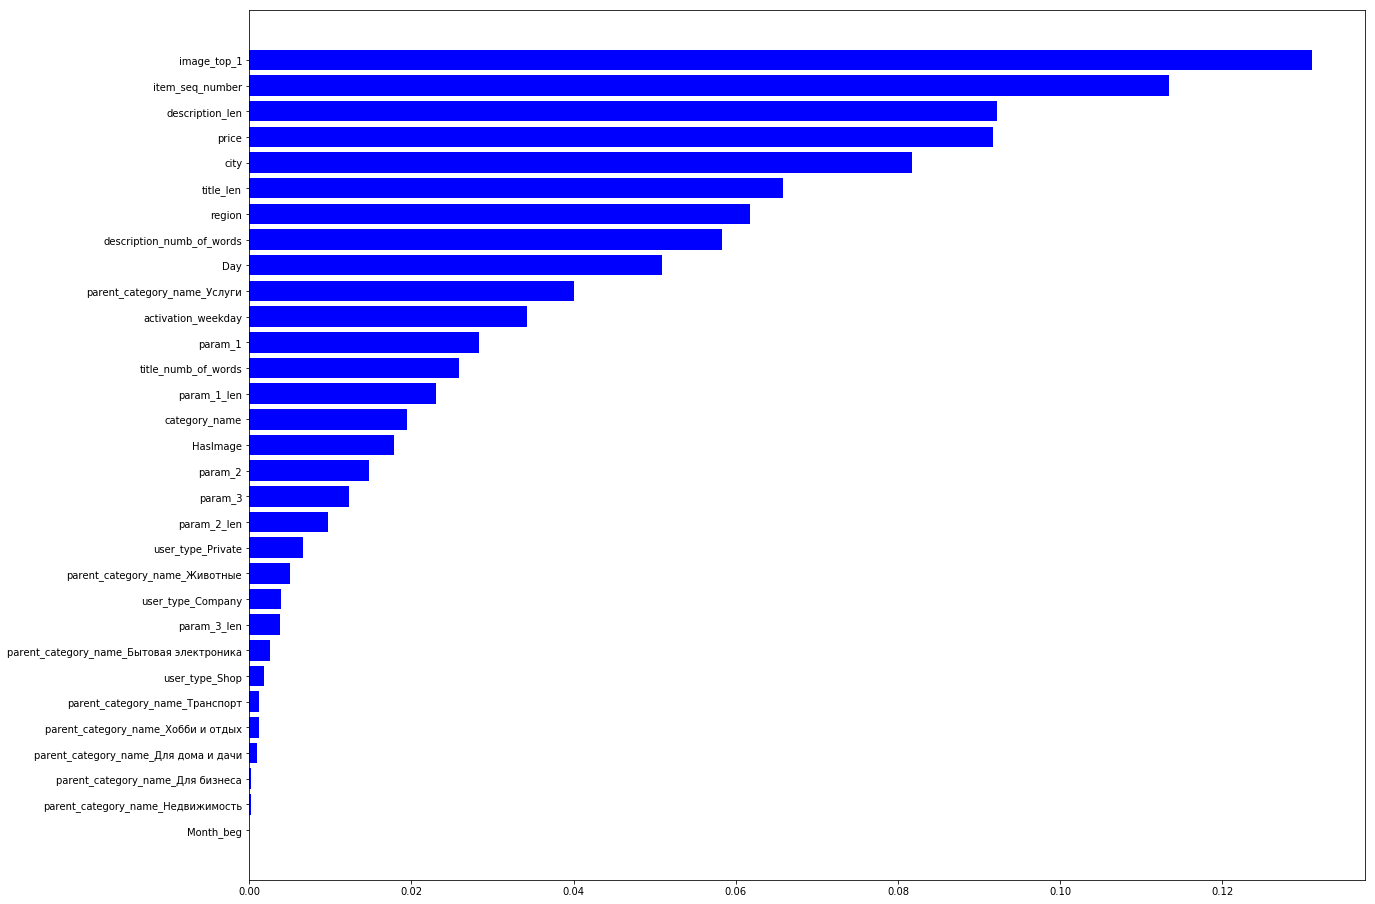

In [159]:
features = train.columns
importances = clf_rf.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices].str.decode('utf-8'))

# plt.plot(clf_rf.feature_importances_)
plt.show()

In [172]:
# np.unique(train.Month_beg)
# train.Month_beg.value_counts()
len(train.loc[train.Day>15])
# len(train.loc[train.Day<=16])

1394800

## Finding optimal parameters for xgb

In [116]:
dtrain = xgb.DMatrix(X_train, y_train)
Y = y_train
params = {
  'min_child_weight':(1, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 10)
}                            
# Initialize BO optimizer
xgb_bayesopt = BayesianOptimization(train_xgb, params)

# Maximize rmse score
xgb_bayesopt.maximize(init_points=5, n_iter=25)

# Get the best params
p = xgb_bayesopt.res['max']['max_params']

print p

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 04m15s |    0.25958 |             0.7267 |    3.5475 |      2.1877 |            18.6128 |      0.7585 | 
    2 | 02m54s |    0.25962 |             0.3411 |    2.4683 |      2.7650 |            18.4106 |      0.6586 | 
    3 | 03m40s |    0.25954 |             0.4748 |    5.8650 |      3.6726 |            15.4966 |      0.7573 | 
    4 | 02m38s |    0.25958 |             0.2102 |    2.9246 |      4.7394 |            18.6161 |      0.9752 | 
    5 | 16m57s |    0.25935 |             0.9452 | 

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00125496]), 'nit': 5, 'funcalls': 47}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00125496]), 'nit': 4, 'funcalls': 46}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00172516]), 'nit': 3, 'funcalls': 64}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning

   4.3212 |      8.8355 |             7.7902 |      0.8746 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    6 | 24m34s |    0.25947 |             0.9290 |    2.1507 |      4.6261 |            15.9479 |      0.9228 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00021033]), 'nit': 9, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.84407331e-05]), 'nit': 6, 'funcalls': 64}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.21541935e-05]), 'nit': 8, 'funcalls': 68}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: U

    7 | 03m35s |    0.25958 |             0.6761 |    2.7689 |      2.9602 |             9.1987 |      0.8061 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00049499]), 'nit': 7, 'funcalls': 69}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00040029]), 'nit': 6, 'funcalls': 50}
  " state: %s" % convergence_dict)


    8 | 17m57s |    0.25950 |             0.3913 |    4.1942 |      5.6736 |             4.7904 |      0.9848 | 

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00087287]), 'nit': 8, 'funcalls': 113}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00205636]), 'nit': 7, 'funcalls': 62}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -7.42072923e-05]), 'nit': 6, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserW


    9 | 03m51s |    0.25953 |             0.5465 |    1.8511 |      3.9500 |            18.4243

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00019179]), 'nit': 6, 'funcalls': 69}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00042589]), 'nit': 4, 'funcalls': 63}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.46433117e-05]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWa

 |      0.9067 | 
   10 | 02m50s |    0.25959 |             0.4559 |    3.6580 |      2.8358 |             7.8511 |      0.5819 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00071478]), 'nit': 7, 'funcalls': 92}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0001642]), 'nit': 5, 'funcalls': 77}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00028995]), 'nit': 6, 'funcalls': 83}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning:

   11 | 39m54s |    0.25944 |             0.9737 |    1.8197 | 

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00029035]), 'nit': 6, 'funcalls': 63}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00048182]), 'nit': 8, 'funcalls': 72}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01112006]), 'nit': 7, 'funcalls': 53}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning

     5.3971 |            13.8048 |      0.9101 | 
   12 | 02m22s |    0.25962 |             0.3108 |    6.8362 |      2.0774 |             2.4490 |      0.8984 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00040873]), 'nit': 8, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01060829]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00045244]), 'nit': 8, 'funcalls': 52}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning

   13 | 66m51s |    0.25962 |             0.3526 |    8.2824 |      2.3549 |            12.5350 |      0.9680

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00075283]), 'nit': 10, 'funcalls': 111}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0022216]), 'nit': 7, 'funcalls': 126}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00632114]), 'nit': 8, 'funcalls': 115}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarn

 | 
   14 | 20m26s |    0.25950 |             0.9688 |    0.2659 |      3.5931 |             9.5108 |      0.7056 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00018107]), 'nit': 9, 'funcalls': 70}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00019558]), 'nit': 8, 'funcalls': 108}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00133663]), 'nit': 11, 'funcalls': 130}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarn

   15 | 14m20s |    0.25943 |             0.7871 |    4.4182

/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.14120698e-05]), 'nit': 9, 'funcalls': 53}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00478219]), 'nit': 10, 'funcalls': 106}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00125134]), 'nit': 7, 'funcalls': 92}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: User

 |      6.4833 |            17.3593 |      0.6696 | 
   16 | 428m19s |    0.25946 |             0.7437 |    4.4579 |      5.8788 |            11.8721 |      0.8217 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00033947]), 'nit': 6, 'funcalls': 77}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00167935]), 'nit': 8, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0063942]), 'nit': 9, 'funcalls': 96}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning:

   17 | 05m34s |    0.25951 |             0.4416 |    1.2117 |      4.9826 |            17.6357 |      0.9037 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00905105]), 'nit': 8, 'funcalls': 78}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00148903]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.41009077e-05]), 'nit': 8, 'funcalls': 54}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWa

   18 | 16m27s |    0.25939 |             0.8561 |    6.5688 |      7.4519 |             1.1488 |      0.5227 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00056724]), 'nit': 10, 'funcalls': 88}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  9.89445169e-05]), 'nit': 8, 'funcalls': 66}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00113662]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserW

   19 | 02m23s |    0.25973 |             0.1274 |    1.3042 |      4.3824 |            12.6514 |      0.9913 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.84979290e-05]), 'nit': 6, 'funcalls': 75}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00153801]), 'nit': 6, 'funcalls': 72}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.25231051e-05]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: U

   20 | 21m13s |    0.25935 |             0.8504 |    7.2954 |      9.3372 |            14.5644 |      0.5408 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00229519]), 'nit': 7, 'funcalls': 80}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.70809576e-05]), 'nit': 3, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00042005]), 'nit': 7, 'funcalls': 66}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWa

   21 | 03m50s |    0.25958 |             0.1957 |    3.3940 |      4.5325 |            15.9743 |      0.5284 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.50965017e-05]), 'nit': 6, 'funcalls': 63}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.03317919]), 'nit': 4, 'funcalls': 61}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00852599]), 'nit': 3, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWa

   22 | 02m51s |    0.25969 |             0.1363 |    8.0817 |      2.7992 |            10.0306 |      0.8704 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00169557]), 'nit': 6, 'funcalls': 68}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.90127175e-05]), 'nit': 5, 'funcalls': 57}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.57040374e-05]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: U

   23 | 06m46s |    0.25954 |             0.4728 |    3.3741 |      3.6532 |             5.9262 |      0.9797 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.54300675e-05]), 'nit': 9, 'funcalls': 77}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.55139714e-05]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00027754]), 'nit': 4, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: U

   24 | 06m07s |    0.25958 |             0.7776 |    3.1947 |      2.1602 |             9.7642 |      0.5163 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.37393431e-05]), 'nit': 9, 'funcalls': 87}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.25878648e-05]), 'nit': 6, 'funcalls': 71}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.48244326e-05]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:4

   25 | 02m38s |    0.25973 |             0.1041 |    8.4651 |      5.0578 |            12.5631 |      0.5560 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00574783]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.19555402e-05]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.32569873e-05]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: U

   26 | 12m06s |    0.25941 |             0.8165 |    2.0939 |      6.5818 |            10.2147 |      0.6828 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00013899]), 'nit': 4, 'funcalls': 58}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.02038637]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.48126011e-05]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWa

   27 | 13m47s |    0.25941 |             0.9316 |    8.8762 |      6.2818 |             8.4648 |      0.7506 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.21295452e-05]), 'nit': 6, 'funcalls': 76}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -5.07459044e-05]), 'nit': 6, 'funcalls': 85}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.20140612e-05]), 'nit': 7, 'funcalls': 51}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:4

   28 | 03m11s |    0.25958 |             0.5638 |    0.2886 |      2.6974 |            15.2570 |      0.8071 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.93757766e-05]), 'nit': 8, 'funcalls': 63}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  5.21567999e-05]), 'nit': 5, 'funcalls': 67}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.55897893e-05]), 'nit': 8, 'funcalls': 88}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:4

   29 | 04m04s |    0.25963 |             0.1447 |    8.4147 |      8.7096 |             5.3794 |      0.5119 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00023524]), 'nit': 6, 'funcalls': 65}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00597782]), 'nit': 3, 'funcalls': 58}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00034139]), 'nit': 6, 'funcalls': 63}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning

   30 | 06m39s |    0.25944 |             0.4328 |    3.6629 |      7.6152 |             1.2889 |      0.8764 | 


/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.22968665e-05]), 'nit': 8, 'funcalls': 66}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -8.54541577e-05]), 'nit': 6, 'funcalls': 64}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.93995797e-05]), 'nit': 7, 'funcalls': 51}
  " state: %s" % convergence_dict)
/Users/bbb/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:4

{'subsample': 0.55604562020224235, 'colsample_bytree': 0.10407208174818593, 'min_child_weight': 12.563148316505455, 'gamma': 8.4650552434599167, 'max_depth': 5.0578303082889278}


## Print results to csv

In [19]:
file_numb = 1

In [24]:
file_numb = file_numb+1
with open('submission_xgb_'+str(file_numb)+'.csv', "w") as out:
    out.write("item_id,deal_probability\n")
    len_test = len(test_raw)
    rows = ['']*len_test
    rows[0] = '%s,%f \n' % (test_raw.iloc[0,0],0.096158)
    for num in range(1,len_test):
        rows[num]='%s,%f \n' % (test_raw.iloc[num,0],max(y_xgb_test[num-1],0))
    out.writelines(rows)

In [109]:
y_xgb_test+=0.086469471

In [111]:
type(y_xgb_test)

numpy.ndarray

In [ ]:
y_xgb_test